In [2]:
import os, ast
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from PIL import Image

EXPT_DIR = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_6")
)
print("Experiment dir:", EXPT_DIR)

NL_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir,
                 "external_data", "nlp4neuro")
)
print("NL root:", NL_ROOT)

IMG_PATTERN = os.path.join(NL_ROOT, "fish{fish}_images")
fish_list   = [11, 12, 13]

# Overlay settings
TOP_K, DOT_COLOR, DOT_EDGE, DOT_ALPHA = 20, "gray", "white", 0.8
DOT_MIN, DOT_MAX = 50, 300


Experiment dir: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_6
NL root: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro


In [3]:
import os
import h5py

# point this at the file you want to inspect
fish = 11
h5_path = os.path.join(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir,
                                  "external_data", "nlp4neuro", f"fish{fish}_images")),
    "functional_types_df.h5"
)

# print("Inspecting:", h5_path)
import pandas as pd

# pd.read_hdf(h5_path)

## Just draw the calcium images...

In [4]:
import os, glob
import numpy as np, matplotlib.pyplot as plt, tifffile

# ── helper 3: brighten background image ─────────────────────────────────────────
def bright_plane0_image(fish_id, boost=1.5):
    img_path = glob.glob(os.path.join(IMG_PATTERN.format(fish=fish_id),"plane_0.*"))[0]
    im = tifffile.imread(img_path).astype(float)
    im = (im - im.min()) / (im.max() - im.min())
    return np.clip(im * boost, 0, 1)

bg11 = bright_plane0_image(11)

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
ax.imshow(bg11, cmap='viridis', vmin=0, vmax=1)

# add label in white at top-left corner
# ax.text(0.01, 0.99, "GCaMP6s",
#         transform=ax.transAxes,
#         color='white',
#         fontsize=16,
#         fontweight='bold',
#         va='top', ha='left')

ax.axis('off')

out = os.path.join(EXPT_DIR, "fish11_calcium2.pdf")
fig.savefig(out,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
            dpi=300)
plt.close(fig)

print("saved:", out)


saved: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_6\fish11_calcium2.pdf


In [5]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell 2 (updated): helpers + saliency overlays + region overlay + bar-plot
# ────────────────────────────────────────────────────────────────────────────────
import os, glob, ast
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tifffile
from matplotlib import cm                       # colour map

# ── helper 1: average saliency vector ───────────────────────────────────────────
def load_all_importances(fish_id):
    base = os.path.join(EXPT_DIR, f"fish{fish_id}")
    mats = [np.load(os.path.join(r, "importance.npy"))
            for r,_,fs in os.walk(base) if "importance.npy" in fs]
    return np.vstack(mats).mean(0)              # (neurons_total,)

# ── helper 2: plane-0 table  → sal, coords, region ─────────────────────────────
def plane0_data(fish_id):
    img_dir = IMG_PATTERN.format(fish=fish_id)
    h5 = os.path.join(img_dir, "functional_types_df.h5")
    df = pd.read_hdf(h5)
    df0 = df[df["plane"] == "plane_0"]
    sal0 = load_all_importances(fish_id)[df0.index.values.astype(int)]
    coords0 = np.vstack(df0["neur_coords"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x,str) else x))
    regs0 = df0["region"].fillna("unknown").values
    return sal0, coords0, regs0

# ── helper 3: brighten background image ─────────────────────────────────────────
def bright_plane0_image(fish_id, boost=1.5):
    img_path = glob.glob(os.path.join(IMG_PATTERN.format(fish=fish_id),"plane_0.*"))[0]
    im = tifffile.imread(img_path).astype(float)
    im = (im-im.min())/(im.max()-im.min())      # 0-1
    return np.clip(im*boost,0,1)                # brighten

# store per-fish region saliency for bar-plot
region_maps = []

TOP_K = 8

# ---------- A) overlay top-K saliency dots (transparent PDF) -------------------
for fish in fish_list:
    sal0, coords0, regs0 = plane0_data(fish)
    top = np.argsort(sal0)[-TOP_K:][::-1]
    sizes = ((sal0[top]-sal0[top].min()) /
             (np.ptp(sal0[top])+1e-9))*(DOT_MAX-DOT_MIN)+DOT_MIN

    bg = bright_plane0_image(fish)              # grayscale & bright
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(bg, cmap="gray", vmin=0, vmax=1)
    ax.scatter(coords0[top,0], coords0[top,1],
               s=sizes, c="red", edgecolors="white", alpha=.8)
    ax.axis("off"); fig.patch.set_alpha(0); ax.patch.set_alpha(0)

    out = os.path.join(EXPT_DIR, f"fish{fish}_overlay.pdf")
    fig.savefig(out, transparent=True, bbox_inches="tight")
    plt.close(fig)
    print("saved:", out)

    # region means for bar-plot
    region_maps.append(pd.DataFrame({"sal":sal0,"reg":regs0})
                       .groupby("reg")["sal"].mean())

# ---------- B) region overlay (fish 11) + C) bar-plot --------------------------
# ❶ pick the regions that truly exist (<= REGION_K)
overall_mean = pd.concat(region_maps, axis=1).mean(1)
top_regs     = overall_mean.nlargest(REGION_K).index.tolist()
n_reg        = len(top_regs)                      # could be < REGION_K
colors       = cm.tab10(np.arange(n_reg))         # exactly n_reg colours

# -- region overlay on fish 11 ---------------------------------------------------
sal11, coords11, regs11 = plane0_data(11)
bg11 = bright_plane0_image(11)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(bg11, cmap="gray", vmin=0, vmax=1)
for i, r in enumerate(top_regs):
    mask = regs11 == r
    ax.scatter(coords11[mask,0], coords11[mask,1],
               s=50, c=[colors[i]], edgecolors="white")
ax.axis("off"); fig.patch.set_alpha(0); ax.patch.set_alpha(0)

out = os.path.join(EXPT_DIR, "fish11_regions_overlay.pdf")
fig.savefig(out, transparent=True, bbox_inches="tight")
plt.close(fig)
print("saved:", out)

# -- bar-plot across the three fish --------------------------------------------
data = []
for m in region_maps:                       # each m is a Series
    data.append(m.reindex(top_regs).values) # align & keep NaNs

data   = np.vstack(data)                    # shape (3, n_reg)
means  = np.nanmean(data, axis=0)
sems   = np.nanstd(data,  ddof=1, axis=0) / np.sqrt(len(fish_list))

fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(n_reg)
ax.bar(x, means, yerr=sems, capsize=5, color=colors)
ax.set_xticks(x)
ax.set_xticklabels(top_regs, rotation=45, ha="right")
ax.set_ylabel("Mean saliency ± SEM")
fig.patch.set_alpha(0)

out = os.path.join(EXPT_DIR, "region_importance_barplot.pdf")
fig.savefig(out, transparent=True, bbox_inches="tight")
plt.close(fig)
print("saved:", out)

saved: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_6\fish11_overlay.pdf
saved: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_6\fish12_overlay.pdf
saved: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_6\fish13_overlay.pdf


NameError: name 'REGION_K' is not defined

In [ ]:
# -------------------- CLUSTERING + OVERLAY + BARPLOT (K=8) --------------------
NEW_K      = 8
TOP_K      = 20                         # keep your existing constant
new_letters = list("ABCDEFGH")[:NEW_K]  # fixed letter list

from sklearn.cluster import KMeans
from scipy.stats import ttest_rel
from scipy.spatial import ConvexHull
import matplotlib.patheffects as pe
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from matplotlib import cm

# ──────────────────────────────────────────────────────────────────────────────
# 1) ELBOW PLOT  (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
Ks, inertias = [], []
for k in range(2, 16):
    Ks.append(k)
    inertias.append(
        KMeans(n_clusters=k, random_state=0).fit(
            np.vstack([
                plane0_data(f)[1][np.argsort(plane0_data(f)[0])[-TOP_K:]]
                for f in fish_list
            ])
        ).inertia_
    )

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(Ks, inertias, "-o")
ax.set_xlabel("K")
ax.set_ylabel("Inertia")
ax.axvline(NEW_K, linestyle="--", color="red")
fig.savefig(os.path.join(EXPT_DIR, "elbow_plot.pdf"),
            transparent=True, bbox_inches="tight")
plt.show()
plt.close(fig)

In [43]:
# -------------------- CLUSTERING + OVERLAY + BARPLOT (K=8) --------------------
NEW_K      = 8
TOP_K      = 20                         # keep your existing constant
new_letters = list("ABCDEFGH")[:NEW_K]  # fixed letter list

from sklearn.cluster import KMeans
from scipy.stats import ttest_rel
from scipy.spatial import ConvexHull
import matplotlib.patheffects as pe
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from matplotlib import cm

# ──────────────────────────────────────────────────────────────────────────────
# 1) ELBOW PLOT  (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
Ks, inertias = [], []
for k in range(2, 16):
    Ks.append(k)
    inertias.append(
        KMeans(n_clusters=k, random_state=0).fit(
            np.vstack([
                plane0_data(f)[1][np.argsort(plane0_data(f)[0])[-TOP_K:]]
                for f in fish_list
            ])
        ).inertia_
    )

fig, ax = plt.subplots()
ax.plot(Ks, inertias, "-o")
ax.set_xlabel("K")
ax.set_ylabel("Inertia")
ax.axvline(NEW_K, linestyle="--", color="red")
fig.savefig(os.path.join(EXPT_DIR, "elbow_plot.pdf"),
            transparent=True, bbox_inches="tight")
plt.close(fig)

# ──────────────────────────────────────────────────────────────────────────────
# 2) K-MEANS CLUSTERING  (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
K_star = NEW_K
xy_pool = np.vstack([
    plane0_data(f)[1][np.argsort(plane0_data(f)[0])[-TOP_K:]]
    for f in fish_list
])
km = KMeans(n_clusters=K_star, random_state=0).fit(xy_pool)

cluster_tables = []
for f in fish_list:
    sal, coords, _ = plane0_data(f)
    labels = km.predict(coords)
    cluster_tables.append(pd.DataFrame({
        "sal": sal,
        "cl":  labels,
        "x":   coords[:, 0],
        "y":   coords[:, 1]
    }))

# ──────────────────────────────────────────────────────────────────────────────
# 3) COMPUTE MEANS / SEMs  +  LETTER MAP
# ──────────────────────────────────────────────────────────────────────────────
means = np.array([tbl.groupby("cl")["sal"].mean() for tbl in cluster_tables]).mean(0)
sems  = np.array([tbl.groupby("cl")["sal"].mean() for tbl in cluster_tables]).std(axis=0, ddof=1) / np.sqrt(len(fish_list))

# assign letters **before** ordering
letter_map = {cl: new_letters[cl] for cl in range(K_star)}
order      = np.argsort(means)[::-1]    # index list of clusters high→low

# ──────────────────────────────────────────────────────────────────────────────
# 4) OVERLAY ON FISH 11  (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
sal11, coords11, _ = plane0_data(11)
labels11 = km.predict(coords11)
bg      = bright_plane0_image(11)
colors  = cm.tab10(np.arange(K_star))

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(bg, cmap="gray", vmin=0, vmax=1)
for cl in range(K_star):
    pts = coords11[labels11 == cl]
    if pts.size == 0:
        continue
    ax.scatter(pts[:, 0], pts[:, 1], s=30,
               c=[colors[cl]], edgecolors="white", alpha=0.8)
    if len(pts) >= 3:
        hull = ConvexHull(pts)
        poly = pts[hull.vertices]
        ax.plot(*poly.T, linestyle=":", linewidth=1.5, color="white")
    cx, cy = pts.mean(axis=0)
    ax.text(cx, cy, letter_map[cl],
            color="white", fontsize=12, weight="bold",
            ha="center", va="center",
            path_effects=[pe.Stroke(linewidth=2, foreground="black"), pe.Normal()])
ax.axis("off")
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
fig.savefig(os.path.join(EXPT_DIR, "fish11_clusters_overlay.pdf"),
            transparent=True, bbox_inches="tight")
plt.close(fig)

# ──────────────────────────────────────────────────────────────────────────────
# 5) BARPLOT  (edited section)
# ──────────────────────────────────────────────────────────────────────────────
data = np.vstack([
    tbl.groupby("cl")["sal"].mean().reindex(order).values
    for tbl in cluster_tables
])  # shape: (n_fish, K_star)

bar_means = data.mean(axis=0)
bar_sems  = data.std(axis=0, ddof=1) / np.sqrt(len(fish_list))

fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(K_star)
ax.bar(x, bar_means, yerr=bar_sems, capsize=5, color=colors[order])

# xtick labels in *ranked* order but fixed letters
ax.set_xticks(x)
ax.set_xticklabels([letter_map[cl] for cl in order], fontsize=12)

ax.set_ylabel("Saliency")
ax.set_ylim(bottom=0.0004)

# -------- significance brackets --------
def bracket(ax, x1, x2, y, h, star):
    """Draw a bracket with text"""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black")
    ax.text((x1+x2)/2, y+h*1.1, star, ha="center", va="bottom", fontsize=12)

# place brackets just above bars (lower than before)
y_base = bar_means.max() * 1.02
h      = bar_means.max() * 0.015
for i in range(K_star - 1):
    for j in range(i + 1, K_star):
        t, p = ttest_rel(data[:, i], data[:, j], nan_policy="omit")
        p_one = p / 2 if t > 0 else 1.0  # one-tailed
        if p_one < 0.05:
            star = "***" if p_one < 0.001 else "**" if p_one < 0.01 else "*"
            bracket(ax, i, j, y_base, h, star)
            y_base += h * 2             # stack brackets upward

fig.patch.set_alpha(0)
fig.savefig(os.path.join(EXPT_DIR, "cluster_importance_barplot.pdf"),
            transparent=True, bbox_inches="tight")
plt.close(fig)

print("All figures saved.")



Paired one-tailed t-tests (higher > lower) -----------------------
D vs E:  t = +0.107,  p_one = 0.4622
D vs H:  t = +0.972,  p_one = 0.2168
D vs B:  t = +1.334,  p_one = 0.1569
D vs C:  t = +1.423,  p_one = 0.1454
D vs A:  t = +0.813,  p_one = 0.2507
D vs F:  t = +1.786,  p_one = 0.1080
D vs G:  t = +2.034,  p_one = 0.0894
E vs H:  t = +0.446,  p_one = 0.3498
E vs B:  t = +0.935,  p_one = 0.2241
E vs C:  t = +0.662,  p_one = 0.2881
E vs A:  t = +0.493,  p_one = 0.3354
E vs F:  t = +0.994,  p_one = 0.2124
E vs G:  t = +1.027,  p_one = 0.2062
H vs B:  t = +0.000,  p_one = 0.4999
H vs C:  t = +0.457,  p_one = 0.3463
H vs A:  t = +0.489,  p_one = 0.3366
H vs F:  t = +1.063,  p_one = 0.1996
H vs G:  t = +3.184,  p_one = 0.0430
B vs C:  t = +0.197,  p_one = 0.4311
B vs A:  t = +0.199,  p_one = 0.4304
B vs F:  t = +0.566,  p_one = 0.3142
B vs G:  t = +0.901,  p_one = 0.2313
C vs A:  t = +0.159,  p_one = 0.4440
C vs F:  t = +2.277,  p_one = 0.0752
C vs G:  t = +0.810,  p_one = 0.2515
A vs F:


Paired one-tailed t-tests (higher > lower) -----------------------
D vs E:  t = +0.107,  p_one = 0.4622
D vs H:  t = +0.972,  p_one = 0.2168
D vs B:  t = +1.334,  p_one = 0.1569
D vs C:  t = +1.423,  p_one = 0.1454
D vs A:  t = +0.813,  p_one = 0.2507
D vs F:  t = +1.786,  p_one = 0.1080
D vs G:  t = +2.034,  p_one = 0.0894
E vs H:  t = +0.446,  p_one = 0.3498
E vs B:  t = +0.935,  p_one = 0.2241
E vs C:  t = +0.662,  p_one = 0.2881
E vs A:  t = +0.493,  p_one = 0.3354
E vs F:  t = +0.994,  p_one = 0.2124
E vs G:  t = +1.027,  p_one = 0.2062
H vs B:  t = +0.000,  p_one = 0.4999
H vs C:  t = +0.457,  p_one = 0.3463
H vs A:  t = +0.489,  p_one = 0.3366
H vs F:  t = +1.063,  p_one = 0.1996
H vs G:  t = +3.184,  p_one = 0.0430
B vs C:  t = +0.197,  p_one = 0.4311
B vs A:  t = +0.199,  p_one = 0.4304
B vs F:  t = +0.566,  p_one = 0.3142
B vs G:  t = +0.901,  p_one = 0.2313
C vs A:  t = +0.159,  p_one = 0.4440
C vs F:  t = +2.277,  p_one = 0.0752
C vs G:  t = +0.810,  p_one = 0.2515
A vs F:

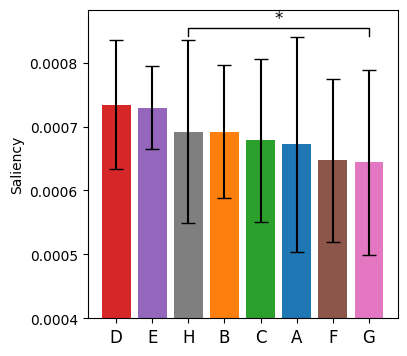


Saved cluster_importance_barplot.pdf


In [53]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) BARPLOT  – correct bracket height + print p-values
# ──────────────────────────────────────────────────────────────────────────────
data = np.vstack([
    tbl.groupby("cl")["sal"].mean().reindex(order).values
    for tbl in cluster_tables
])                                                   # shape = (n_fish, K)

bar_means = data.mean(axis=0)
bar_sems  = data.std(axis=0, ddof=1) / np.sqrt(len(fish_list))

fig, ax = plt.subplots(figsize=(4, 4))
x = np.arange(K_star)
ax.bar(x, bar_means, yerr=bar_sems, capsize=5, color=colors[order])

ax.set_xticks(x)
ax.set_xticklabels([letter_map[cl] for cl in order], fontsize=12)
ax.set_ylabel("Saliency")
ax.set_ylim(bottom=0.0004)             # keep fixed baseline

# -------- significance brackets & p-value log --------
def draw_bracket(ax, x1, x2, y, h, star):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black")
    ax.text((x1+x2)/2, y+h*1.1, star, ha="center",
            va="bottom", fontsize=12, color="black")

print("\nPaired one-tailed t-tests (higher > lower) -----------------------")
for i in range(K_star - 1):
    for j in range(i + 1, K_star):
        t, p_two = ttest_rel(data[:, i], data[:, j], nan_policy="omit")
        p_one = p_two / 2 if t > 0 else 1.0
        print(f"{letter_map[order[i]]} vs {letter_map[order[j]]}:  "
              f"t = {t:+.3f},  p_one = {p_one:.4f}")
        if p_one < 0.05:
            # place bracket just above the tallest bar + error among this pair
            y_top = max(bar_means[[i, j]] + bar_sems[[i, j]])
            h = y_top * 0.015
            star = "***" if p_one < 0.001 else "**" if p_one < 0.01 else "*"
            draw_bracket(ax, i, j, y_top + h * .5, h, star)

fig.patch.set_alpha(0)
fig.savefig(os.path.join(EXPT_DIR, "cluster_importance_barplot.pdf"),
            transparent=True, bbox_inches="tight")
plt.show()
plt.close(fig)

print("\nSaved cluster_importance_barplot.pdf")


# top 20 and bot 20 per each fish

In [42]:
# ────────────────────────────────────────────────────────────────────────────────
# Cell: Elbow → Cluster on top+bottom extremes → Overlay → Bar‐plot
# ────────────────────────────────────────────────────────────────────────────────
from sklearn.cluster import KMeans
from scipy.stats import friedmanchisquare
from scipy.spatial import ConvexHull
import matplotlib.patheffects as pe

# 1) POOL top-20 & bottom-20 coords from each fish
points = []
for f in fish_list:
    sal0, coords0, _ = plane0_data(f)
    idx_high = np.argsort(sal0)[-TOP_K:]
    idx_low  = np.argsort(sal0)[:TOP_K]
    sel      = np.hstack([idx_high, idx_low])
    points.append(coords0[sel])
xy_pool = np.vstack(points)  # shape (3*40, 2)

# 2) ELBOW PLOT (2…15) saved as elbow_plot.pdf
Ks, inertias = [], []
for k in range(2, 16):
    Ks.append(k)
    inertias.append(KMeans(n_clusters=k, random_state=0).fit(xy_pool).inertia_)
fig, ax = plt.subplots()
ax.plot(Ks, inertias, "-o")
ax.axvline(7, ls="--", c="red")
ax.set(xlabel="Clusters K", ylabel="Inertia")
fig.savefig(os.path.join(EXPT_DIR, "elbow_plot.pdf"),
            transparent=True, bbox_inches="tight")
plt.close(fig)
print("Elbow done—using K=7")

# 3) FINAL K-MEANS (K=7)
K_star = 8
km     = KMeans(n_clusters=K_star, random_state=0).fit(xy_pool)

# 4) ASSIGN & BUILD cluster_tables per fish
cluster_tables = []
for f in fish_list:
    sal0, coords0, _ = plane0_data(f)
    lbl = km.predict(coords0)
    cluster_tables.append(pd.DataFrame({
        "sal": sal0,
        "cl":  lbl,
        "x":   coords0[:,0],
        "y":   coords0[:,1]
    }))

# 5) RANK clusters A…G by descending mean-saliency
per_cl = np.vstack([tbl.groupby("cl")["sal"].mean().reindex(range(K_star)).values
                    for tbl in cluster_tables])
means = per_cl.mean(axis=0)
sems  = per_cl.std(axis=0, ddof=1)/np.sqrt(len(fish_list))
order = np.argsort(means)[::-1]
ABC   = list("ABCDEFG")[:K_star]
letter_map = {cl: ABC[i] for i, cl in enumerate(order)}
colors     = cm.tab10(np.arange(K_star)%10)

# 6) OVERLAY on fish11
tbl11 = cluster_tables[0]
bg11   = bright_plane0_image(11)

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(bg11, cmap="gray", vmin=0, vmax=1)
for cl in range(K_star):
    pts = tbl11.loc[tbl11["cl"]==cl, ["x","y"]].values
    if len(pts)==0: continue
    # scatter
    ax.scatter(pts[:,0], pts[:,1], s=30,
               c=[colors[cl]], edgecolors="white", alpha=0.8)
    # dotted hull
    if len(pts)>=3:
        hull = ConvexHull(pts)
        poly = pts[hull.vertices]
        ax.plot(*poly.T, ls=":", lw=1.5, c="white")
    # letter in white
    cx, cy = pts.mean(axis=0)
    ax.text(cx, cy, letter_map[cl], color="white", weight="bold",
            ha="center", va="center", fontsize=14,
            path_effects=[pe.Stroke(linewidth=3, foreground="black"),
                          pe.Normal()])

ax.axis("off"); fig.patch.set_alpha(0); ax.patch.set_alpha(0)
fig.savefig(os.path.join(EXPT_DIR, "fish11_clusters_overlay.pdf"),
            transparent=True, bbox_inches="tight")
plt.close(fig)
print("Saved fish11_clusters_overlay.pdf")

# 7) BAR PLOT (upward SEM-only) + Friedman test
data = np.vstack([
    tbl.groupby("cl")["sal"].mean().reindex(order).values
    for tbl in cluster_tables
])  # shape (3, 7)
means_ord = data.mean(axis=0)
sems_ord  = data.std(axis=0, ddof=1)/np.sqrt(len(fish_list))

yerr = [np.zeros_like(sems_ord), sems_ord]

fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(K_star)
ax.bar(x, means_ord, yerr=yerr, capsize=5, color=colors[order])
ax.set_xticks(x)
ax.set_xticklabels(ABC[:K_star], fontsize=12)
ax.set_ylabel("Mean saliency (SEM ↑)")

# Friedman test
chi2, pval = friedmanchisquare(*[data[:,i] for i in range(K_star)])
ax.text(0.5, 0.90, f"Friedman p = {pval:.3f}",
        transform=ax.transAxes, ha="center", va="top", fontsize=10)

fig.patch.set_alpha(0)
fig.savefig(os.path.join(EXPT_DIR, "cluster_importance_barplot.pdf"),
            transparent=True, bbox_inches="tight")
plt.close(fig)
print("Saved cluster_importance_barplot.pdf")


KeyboardInterrupt: 